# CarND Object Detection Lab

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
from PIL import ImageFont
import time
from scipy.stats import norm
import matplotlib
import scipy


%matplotlib inline
plt.style.use('ggplot')

/home/han/anaconda3/envs/carnd-advdl-odlab/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/han/anaconda3/envs/carnd-advdl-odlab/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/han/anaconda3/envs/carnd-advdl-odlab/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/han/anaconda3/en

In [2]:
!pip list | grep tensorflow

tensorflow             1.4.0     
tensorflow-plot        0.3.0     
tensorflow-tensorboard 0.4.0     


## *MobileNet* SSD

In this section you'll use a pretrained *MobileNet* [SSD](https://arxiv.org/abs/1512.02325) model to perform object detection. You can download the *MobileNet* SSD and other models from the [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) (*note*: we'll provide links to specific models further below). [Paper](https://arxiv.org/abs/1611.10012) describing comparing several object detection models.

Alright, let's get into SSD!

In [3]:
"""
Frozen inference graph files. NOTE: change the path to where you saved the models.
For this example, I saved the Frozen inference graph(*.pb) in ssd_mobilenet_v1_coco
"""
SSD_GRAPH_FILE = 'onsite_frozen_interface/frozen_inference_graph.pb'

In [4]:
# Use your own color to draw line, box, or text in the image through the PIL module we imported.
ImageColor.colormap    

{'aliceblue': '#f0f8ff',
 'antiquewhite': '#faebd7',
 'aqua': '#00ffff',
 'aquamarine': '#7fffd4',
 'azure': '#f0ffff',
 'beige': '#f5f5dc',
 'bisque': '#ffe4c4',
 'black': '#000000',
 'blanchedalmond': '#ffebcd',
 'blue': '#0000ff',
 'blueviolet': '#8a2be2',
 'brown': '#a52a2a',
 'burlywood': '#deb887',
 'cadetblue': '#5f9ea0',
 'chartreuse': '#7fff00',
 'chocolate': '#d2691e',
 'coral': '#ff7f50',
 'cornflowerblue': '#6495ed',
 'cornsilk': '#fff8dc',
 'crimson': '#dc143c',
 'cyan': '#00ffff',
 'darkblue': '#00008b',
 'darkcyan': '#008b8b',
 'darkgoldenrod': '#b8860b',
 'darkgray': '#a9a9a9',
 'darkgreen': '#006400',
 'darkgrey': '#a9a9a9',
 'darkkhaki': '#bdb76b',
 'darkmagenta': '#8b008b',
 'darkolivegreen': '#556b2f',
 'darkorange': '#ff8c00',
 'darkorchid': '#9932cc',
 'darkred': '#8b0000',
 'darksalmon': '#e9967a',
 'darkseagreen': '#8fbc8f',
 'darkslateblue': '#483d8b',
 'darkslategray': '#2f4f4f',
 'darkslategrey': '#2f4f4f',
 'darkturquoise': '#00ced1',
 'darkviolet': '#9400d3

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [11]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, scores, thickness=4):
    """Draw bounding boxes on the image"""
    
    # Note: Traffic light class should be in this order, 
    # because I defined them in this order before training my model. See the label_map.pbtxt.
    traffic_light = ['Green','Red','GreenLeft','GreenRight','RedLeft','RedRight','Yellow','off', \
                     'RedStraight','GreenStraight','GreenStraightLeft','GreenStraightRight','RedStraightLeft', \
                     'RedStraightRight']
    
    # Utilize PIL.ImageDraw.Draw module.
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        
        # Note: classes is a list starts from 1, not 0. See the label_map.pbtxt.
        class_id = int(classes[i])
        
        # Multiply the class_id by 10, to make the color more.
        color = COLOR_LIST[class_id*10] 
         
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        textsize = 20
        
        # Note: the path to *.tif should be specified in Linux system. Please modify the below line if you 
        # are not using Linux system.
        font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMonoBold.ttf", 28, encoding="unic")
        
        # Utilize Draw.text() func.
        draw.text((left, top), traffic_light[class_id-1]+'='+str(scores[i]*100)[0:4]+'%',font =font, fill='yellow')
    return draw

        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Number of colors = 148


Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

In [12]:
detection_graph = load_graph(SSD_GRAPH_FILE)


# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

Run detection and classification on a sample image.

/home/han/anaconda3/envs/carnd-advdl-odlab/lib/python3.5/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


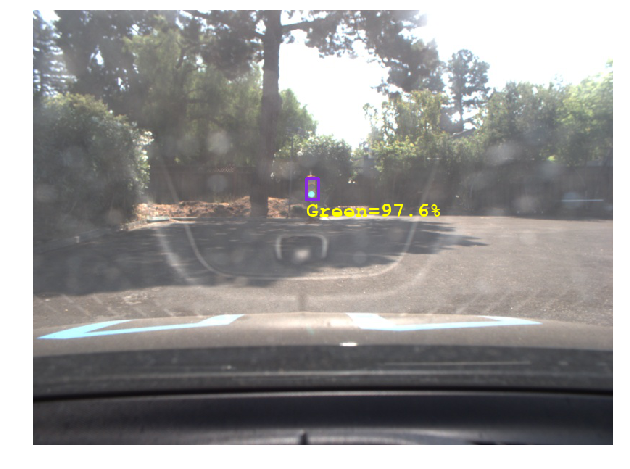

In [14]:
# Load a sample image, the images are inside the 'traffic_light_img' file, 
# choose the one you want to use, or you can bring your 

image = Image.open('./onsite_traffic_light_img/just_traffic_light_0000.jpg')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.8
    # Filter boxes with a confidence score less than `confidence_cutoff`, 
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw = draw_boxes(image, box_coords, classes,scores)
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(image)
    pix = np.array(image)
    scipy.misc.imsave('outfile.jpg', pix)

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [8]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [9]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, 600, 1000, runs=10)

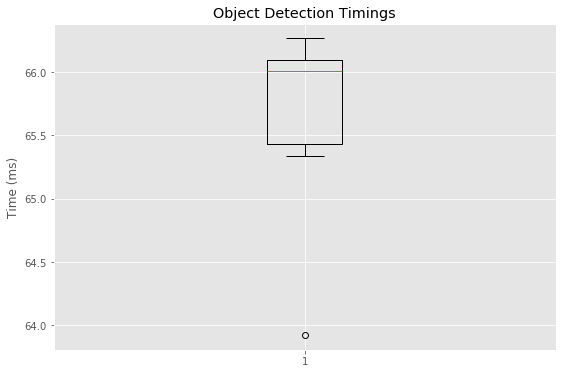

In [10]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

**You can notice that the ssd mobile net is real fast, for my cpu configuration, it detect and classify an object in just about 32 ms.**<br> 